In [1]:
import os
import random

from res_unet import ResUNet
from PIL import Image
from tqdm.notebook import tqdm
from kornia.losses import DiceLoss

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
from torch.nn import functional as F
from torch.nn import Module
from torch.optim import Adam

from matplotlib import pyplot as plt
%matplotlib inline

### 補助関数

In [2]:
def imshow(img1, img2):
    
    img1 = TF.to_pil_image(img1, mode='L')
    img2 = TF.to_pil_image(img2, mode='L')
    
    plt.subplot(121)
    plt.imshow(img1)
    
    plt.subplot(122)
    plt.imshow(img2)
    
    plt.show()    
    
def show_plot(train_loss, val_loss):
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

### global variables

In [3]:
img_dir = './data/image'
label_dir = './data/outline'
checkpoint_dir = './checkpoint'
batch_size = 8
num_epochs = 100
train_file = './data/train.txt'
val_file = './data/val.txt'
test_file = './data/test.txt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### datasets

In [4]:
class MadoriOutlineDS(Dataset):
    
    def _prepare(self, data_file):
        with open(data_file) as f:
            lines = f.readlines()
        f.close()
        self.img_list = []
        self.label_list = []
        for line in lines:
            f_name = line.strip()
            self.img_list += [os.path.join(img_dir, f'{f_name}.jpg')]
            self.label_list += [os.path.join(label_dir, f'{f_name}.png')]
    
    def __init__(self, data_file, img_size=(256, 256)):
        self._prepare(data_file)
        self.img_size = (256, 256)
        
    def __len__(self):
        return len(self.img_list)
    
    def _transform(self, img, label):
        img = img.resize(self.img_size, Image.BILINEAR)
        label = label.resize(self.img_size, Image.BILINEAR)
        
        if random.random() > 0.5:
            rot_degree = random.choice([90, 180, 270])
            img = TF.rotate(img, rot_degree)
            label = TF.rotate(label, rot_degree)
        if random.random() > 0.5:
            img = TF.hflip(img)
            label = TF.hflip(label)
        if random.random() > 0.5:
            img = TF.vflip(img)
            label = TF.vflip(label)
        
        img, label = TF.to_tensor(img), TF.to_tensor(label)
        ones = torch.ones_like(label)
        label = torch.where(label > 0, ones, label)
        return img, label
        #return TF.to_tensor(img), TF.to_tensor(label)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_list[idx]).convert('L')
        label = Image.open(self.label_list[idx]).convert('L')
        return self._transform(img, label)

### data loaders

In [ ]:
train_dl = DataLoader(MadoriOutlineDS(train_file), batch_size=batch_size, shuffle=True)
val_dl = DataLoader(MadoriOutlineDS(val_file), batch_size=batch_size, shuffle=True)

In [ ]:
for i, batch in enumerate(train_dl):
    img, label = batch
    print(img.size(), label.size(), torch.squeeze(label).size())
    for k in range(3):
        imshow(img[k], label[k])
    break

### train & validation

In [ ]:
model = ResUNet().to(device)
criterion = DiceLoss()
optimizer = Adam(model.parameters(), lr=0.0005)

In [ ]:
train_loss_history, val_loss_history = [], []
lowest_epoch_train_loss = lowest_epoch_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_train_loss = 0
    for i, batch in enumerate(train_dl):
        img, label = batch
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(img)
        batch_train_loss = criterion(pred, torch.squeeze(label.long(), dim=1))
        epoch_train_loss += batch_train_loss.item()
        batch_train_loss.backward()
        optimizer.step()
    epoch_train_loss /= (i+1)
    if epoch_train_loss < lowest_epoch_train_loss:
        lowest_epoch_train_loss = epoch_train_loss
        torch.save(model.state_dict(), f'{checkpoint_dir}/best_train.pth')
    train_loss_history += [epoch_train_loss]
    
    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        for i, batch in enumerate(val_dl):
            img, label = batch
            img, label = img.to(device), label.to(device)
            pred = model(img)
            batch_val_loss = criterion(pred, torch.squeeze(label.long(), dim=1))
            epoch_val_loss += batch_val_loss.item()
        epoch_val_loss /= (i+1)
        if epoch_val_loss < lowest_epoch_val_loss:
            lowest_epoch_val_loss = epoch_val_loss
            torch.save(model.state_dict(), f'{checkpoint_dir}/best_val.pth')
        val_loss_history.append(epoch_val_loss)
    print(f'Epoch {epoch} training loss is {epoch_train_loss}, validation loss is {epoch_val_loss}')      

N = 2  # num_classes
loss = DiceLoss()

input = torch.randn(1, N, 3, 5, requires_grad=True)
target = torch.empty(1, 3, 5, dtype=torch.long).random_(N)

output = loss(pred, torch.squeeze(label.long(), dim=1))
output.backward()

In [ ]:
show_plot(train_loss_history, val_loss_history)

### test

In [6]:
model = ResUNet().to(device)
model.load_state_dict(torch.load(f'{checkpoint_dir}/best_val.pth'))
test_dl = DataLoader(MadoriOutlineDS(test_file), batch_size=1, shuffle=False)

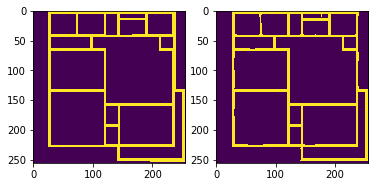

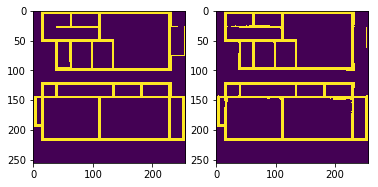

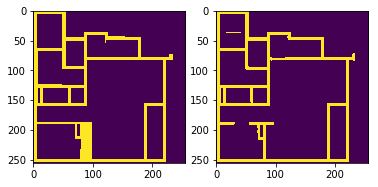

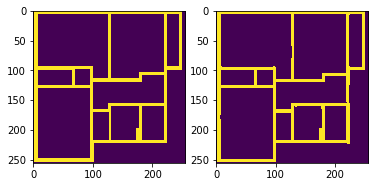

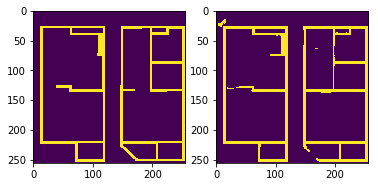

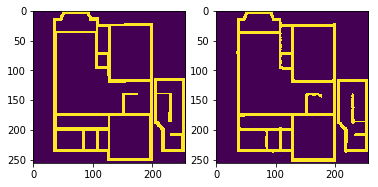

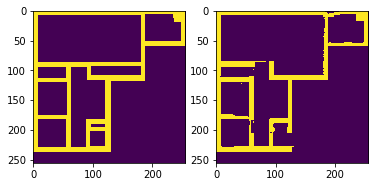

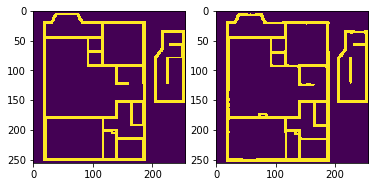

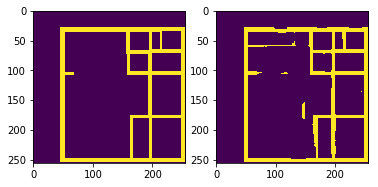

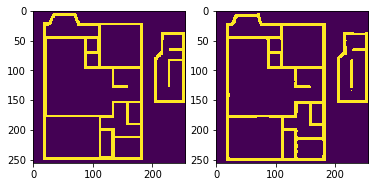

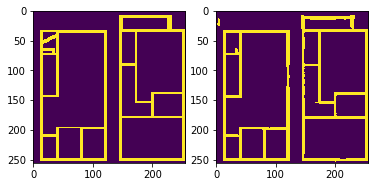

In [7]:
model.eval()
test_results_0 = []
test_results_1 = []
with torch.no_grad():
    for i, batch in enumerate(test_dl):
        if i > 10: break
        img, label = batch
        img, label = img.to(device), label.to(device)
        pred = F.softmax(model(img), dim=1)
        
        img, label, pred = img.cpu(), label.cpu(), pred.cpu()
        
        ones = torch.ones((256, 256))
        zeros = torch.zeros((256, 256))
        
        imshow(label[0], torch.where(pred[0,1] > 0.5, ones, zeros))